# Regression, continued

### Sean Trott

### CSS Bootcamp

In [1]:
## Imports
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import scipy.stats as ss

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

# High-level learning outcomes of this week

##### [Null Hypothesis Significance Testing (NHST)](https://en.wikipedia.org/wiki/Statistical_hypothesis_testing)

- **Explain** the theoretical foundations  
- **Implement** a t-test in Python  
- **Evaluate** the result of a given test


##### [Linear regression](https://en.wikipedia.org/wiki/Linear_regression): 

- **Implement** using Python
- **Interpret** coefficients, **examine** residuals, and **predict** new data  


##### [Beyond linear regression](https://en.wikipedia.org/wiki/Generalized_linear_model): 

- **Explain** the motivation for mixed/multilevel models  
- **Implement** other families of regression models (e.g., logistic regression)

# Today's focus

- **Explain** the motivation for *multivariate linear regression*.  
- **Implement** multiple regression in Python using `statmodels`.  
- **Interpret** the coefficients from multivariate linear regression models.  
- **Explain** the theoretical foundations of logistic regression.

# Part 0: Review

## Last time: linear regression

- Goal: find the **best-fitting line** between $X$ and $Y$.  

 $\Large Y = \beta_0 + \beta_1X_1$  
 
 
- Try to find the parameters $\beta_0, \beta_1$ that minimize **sum squared error**, i.e., $\sum_i^n\hat{y}_i - y_i^2$.  
- $X$ can be either **continuous** or **categorical**. 
 - If **continuous**, $\beta_1$ reflects *average increase in $Y$ for each 1-unit increase in $X$*. 
 - If **categorical**, $\beta_1$ reflects *difference between the means of $Y$ for each category of $X$*.  

# Part 1: Intro to multiple regression

## What about multiple predictors?

- So far, we've focused on **univariate** regression: a single predictor $X$.  
- But we can *extend* this model to include multiple predictors $X_1, ..., X_n$.  

 $\Large Y = \beta_0 + \beta_1X_1  + \beta_2X_2  + ... + \beta_nX_n $
 
 
- In this case, we learn a unique $\beta$ for each predictor.  

## How do we interpret these parameters?

- Each coefficient $\beta_j$ reflects:
 - **Amount of change** in $Y$ associated with changes in $X_j$... 
 - ...holding all other variables **constant** (i.e., *ceteris paribus*).  
- Each prediction $\hat{y}_i$ reflects the *particular features* associated with a given observation $X_i$.  

## Check-in: Why would we even want multiple predictors?

## Why multiple predictors? (pt. 1)

- Oft-cited reason is **statistical control**. 
- If we don't account for **confounds**, we might detect a spurious relationship between $X_1$ and $Y$.
 - E.g., correlation between *shark attacks* and *ice cream sales*.  
  - What is the "hidden variable" here?
- Once we account for a confound, the estimated relationship between $X_1$ and $Y$ might be much smaller or disappear altogether.

## Quick note on causality

- Arguably, controlling for a variable assumes we're interested in [**causal inference**](https://journals.sagepub.com/doi/full/10.1177/25152459221095823).  
- If we just want to quantify the correlation between $X$ and $Y$, we should just measure that.  
- But if we want to **infer** something causal, e.g., $X \to Y$, we need to eliminate alternative explanations.  
 - There's a whole [subfield](http://bayes.cs.ucla.edu/BOOK-2K/) dedicated to the philosophy of causal inference with statistics.  
 - More on causality and confounds later!

## Why multiple predictors? (pt. 2)

- In general, adding more parameters can **improve model fit**. 
 - Though it can also cause **overfitting**.  
- So if our goal is better predictions, adding more variables to the model can add more **information** about $Y$.  
- Caution: we should be *principled* when adding variables.
 - I.e., is there a theoretical reason why this variable should improve the model?  

## Statistical control: a demonstration

- Suppose $Y$ is the rate of shark attacks, which are correlated with temperature ($X_1$).  
- But temperature is also correlated with ice cream sales ($X_2$)...  
- If we just calculate `Y ~ X_2`, we'll probably find a significant coefficient for ice cream sales.  
 - But this would be spurious!

### Setting up our relationships

- First, we create a linear relationship between temperature (in Fahrenheit) and attacks (per million). 

Text(0, 0.5, 'Shark attacks (per million)')

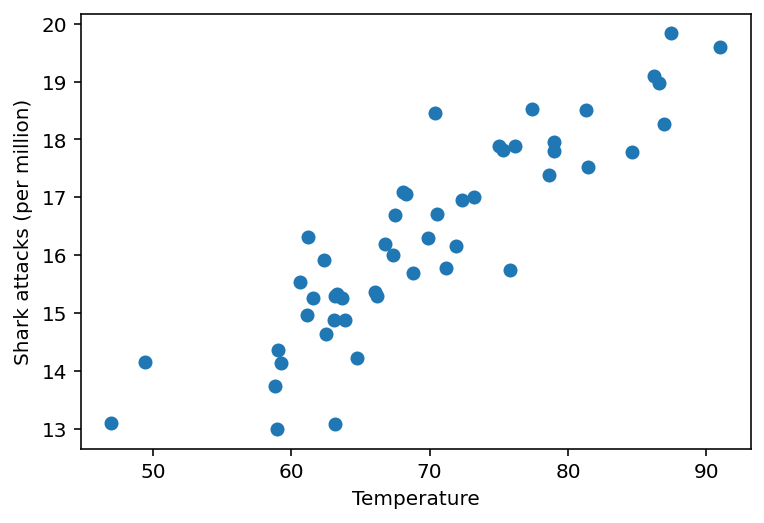

In [34]:
np.random.seed(1)
temperature = np.random.normal(loc = 70, scale = 10, size = 50)
attacks = 5 + temperature * .16 + np.random.normal(loc = 0, scale = 1, size = 50)
plt.scatter(temperature, attacks)
plt.xlabel("Temperature")
plt.ylabel("Shark attacks (per million)")

### Setting up our relationships

- Now, we create a linear relationship between temperature (in Fahrenheit) and ice cream sales (per billion \$). 

Text(0, 0.5, 'Ice cream sales (per billion $)')

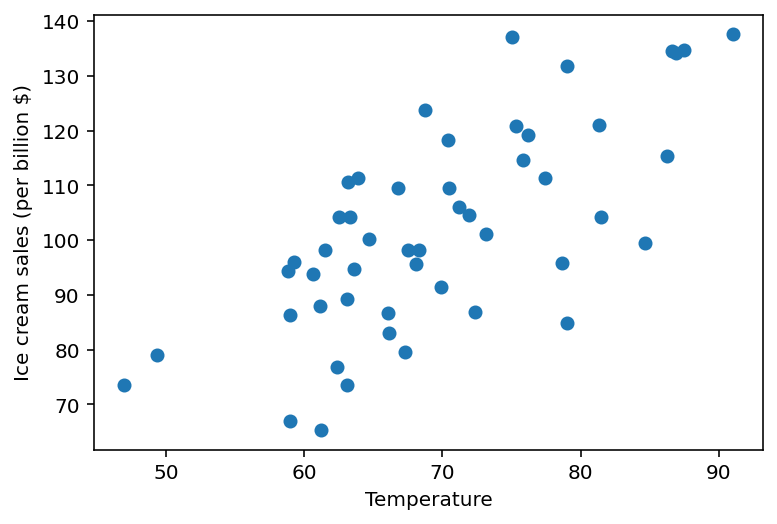

In [35]:
sales = 10 + temperature * 1.3 + np.random.normal(loc = 0, scale = 15, size = 50)
plt.scatter(temperature, sales)
plt.xlabel("Temperature")
plt.ylabel("Ice cream sales (per billion $)")

### A spurious finding

- Now, it looks like there's a significant relationship between ice cream sales and shark attacks!  
- But we *know* that $Y$ was not produced by $X_2$ in the **data-generating process**.  

Text(0.5, 0, 'Ice cream sales (per billion $)')

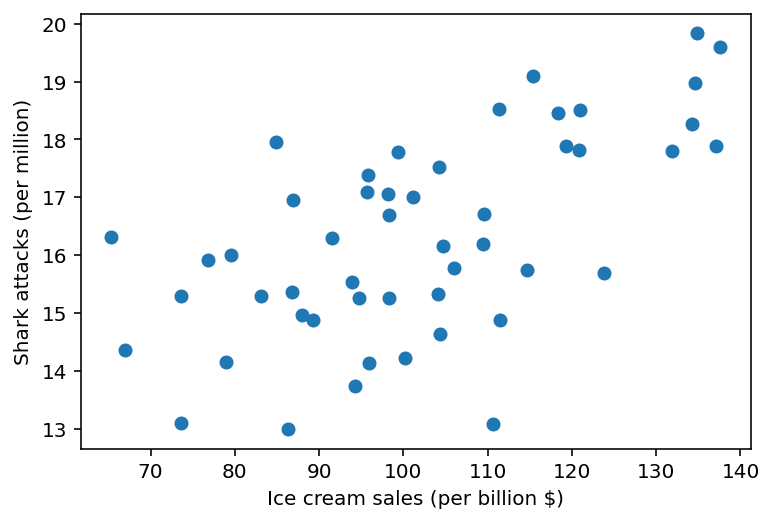

In [36]:
plt.scatter(sales, attacks)
plt.ylabel("Shark attacks (per million)")
plt.xlabel("Ice cream sales (per billion $)")

### A spurious finding

- This spurious result is confirmed by the results of a univariate linear regression.

In [37]:
df = pd.DataFrame({'Attacks': attacks, 'Sales': sales, 'Temperature': temperature})
mod = smf.ols(data = df, formula = "Attacks ~ Sales").fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Attacks   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     29.39
Date:                Fri, 12 Aug 2022   Prob (F-statistic):           1.89e-06
Time:                        15:18:10   Log-Likelihood:                -86.169
No. Observations:                  50   AIC:                             176.3
Df Residuals:                      48   BIC:                             180.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.4552      1.097      9.533      0.000       8.250      12.660
Sales          0.0574      0.011      5.421      0.000       0.036       0.079
==============================================================================
Omnibus:                        1.705   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.426   Jarque-Bera (JB):                1.632
Skew:                          -0.413   Prob(JB):                        0.442
Kurtosis:                       2.682   Cond. No.                         581.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### A spurious finding

- According to the model:
 - For each 1-unit increase in `Sales`, we have a $0.06$ increase in the rate of `Attacks.`. 

In [38]:
mod.params

Intercept    10.455220
Sales         0.057394
dtype: float64

### Adjusting for `Temperature`

- But if we include *both* `Sales` and `Temperature` in the model, we get a different picture. 

In [39]:
mod = smf.ols(data = df, formula = "Attacks ~ Sales + Temperature").fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Attacks   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     90.57
Date:                Fri, 12 Aug 2022   Prob (F-statistic):           7.52e-17
Time:                        15:18:10   Log-Likelihood:                -58.614
No. Observations:                  50   AIC:                             123.2
Df Residuals:                      47   BIC:                             129.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       5.2941      0.831      6.374      0.000       3.623       6.965
Sales          -0.0026      0.009     -0.298      0.767      -0.020       0.015
Temperature     0.1617      0.017      9.721      0.000       0.128       0.195
==============================================================================
Omnibus:                        1.743   Durbin-Watson:                   1.618
Prob(Omnibus):                  0.418   Jarque-Bera (JB):                0.912
Skew:                          -0.195   Prob(JB):                        0.634
Kurtosis:                       3.534   Cond. No.                         911.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Adjusting for `Temperature`

- But if we include *both* `Sales` and `Temperature` in the model, we get a different picture.  
- Holding `Temperature` constant, there's a near-zero predicted change in `Attacks` as `Sales` increases.

In [40]:
print("Coef = {x}, p = {p}".format(x = round(mod.params['Sales'], 4), p = round(mod.pvalues['Sales'], 4)))

Coef = -0.0026, p = 0.7668


## Interim summary

- Multiple regression allows us to include *multiple predictors* in a linear regression model.  
- This is helpful for:
 - Building more accurate models.  
 - Controlling for statistical [confounds, particularly if we're interested in causal inference](https://en.wikipedia.org/wiki/Confounding). 

# Part 2: Multiple regression in Python

## Dataset: Age of Acquisition data

- Let's revisit the `AoA` data we looked at last lecture.  
- Several key variables:
 - `Conc`: how concrete is the word?
 - `SUBTLEX`: how many times did the word occur in a large corpus?
 - `AoA`: at what age, on average, do children learn this word?

In [41]:
df_words = pd.read_csv("data/lecture/words.csv")
df_words.head(2)

,Word,Conc,SUBTLEX,AoA
0,roadsweeper,4.85,0,9.83
1,traindriver,4.54,0,8.34


## Revisiting the concreteness effect

- Last time, we found that `AoA` was significantly related to `Conc` in a linear model.  
- But there's also *independent* evidence that: 
 - **Concreteness** is related to **word frequency**.  
 - **Word frequency** is related to `AoA`.  

What if the **concreteness** finding is spurious? How could we know?

### Adjusting for frequency

- To test this question, we need to add **frequency** to the model.  
- But `SUBTLEX` is extremely right-skewed, so we might want to **log-transform** it.

Text(0.5, 0, 'Log Frequency')

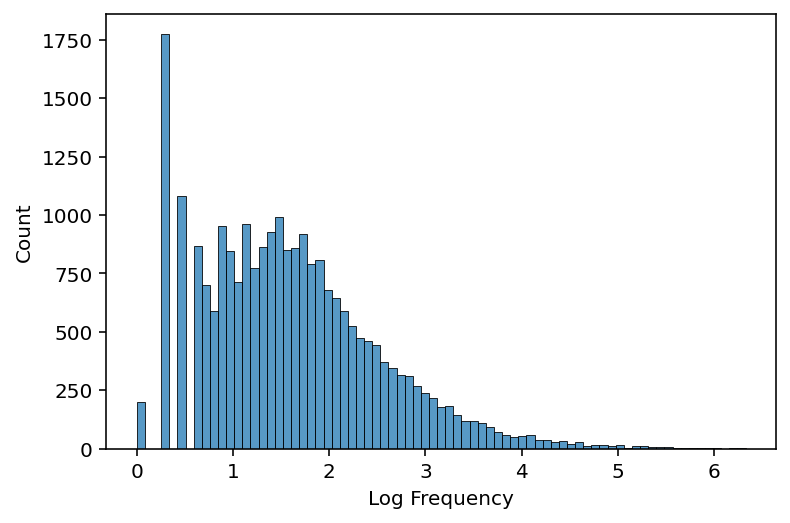

In [42]:
df_words['log_freq'] = np.log10(df_words['SUBTLEX'] + 1)
sns.histplot(data = df_words, x = 'log_freq')
plt.xlabel("Log Frequency")

### Adjusting for frequency

- Now we can build a model with both predictors:
 - `Conc`
 - `log_freq`

In [43]:
mod = smf.ols(data = df_words, formula = "AoA ~ Conc + log_freq").fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    AoA   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                     8792.
Date:                Fri, 12 Aug 2022   Prob (F-statistic):               0.00
Time:                        15:18:12   Log-Likelihood:                -51454.
No. Observations:               23860   AIC:                         1.029e+05
Df Residuals:                   23857   BIC:                         1.029e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.2212      0.047    324.395      0.000      15.129      15.313
Conc          -0.7906      0.013    -59.773      0.000      -0.817      -0.765
log_freq      -1.6037      0.015   -107.886      0.000      -1.633      -1.575
==============================================================================
Omnibus:                       34.875   Durbin-Watson:                   1.837
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.041
Skew:                           0.090   Prob(JB):                     2.46e-08
Kurtosis:                       3.052   Cond. No.                         13.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Inspecting our parameters

**What should we conclude**?

In [44]:
print("Concreteness: Coef = {x}, p = {p}".format(x = round(mod.params['Conc'], 4), 
                                                 p = round(mod.pvalues['Conc'], 4)))
print("Log Frequency: Coef = {x}, p = {p}".format(x = round(mod.params['log_freq'], 4), 
                                                 p = round(mod.pvalues['Conc'], 4)))

Concreteness: Coef = -0.7906, p = 0.0
Log Frequency: Coef = -1.6037, p = 0.0


## Interpreting our model 

- The significant coefficient for `Conc` remains even after controlling for `log_freq`.  
 - I.e., the effect is **robust** to controlling for frequency.
- Further, we replicate the finding that more **frequent** words are learned earlier, on average.  
- Also note that the $R^2$ of the model is considerably higher than a model with only `Conc` (which had $R^2 = .143$)

In [45]:
mod.rsquared

0.42430540232719816

## Check-in: what can we conclude, given that the $R^2$ is so much higher in this model?

## Wrapping up: multiple regression

- Models with multiple predictors can be built using the same function as the univariate models we already discussed. 
- What do the parameters "mean"?
 - **Amount of change** in $Y$ associated with changes in $X_j$... 
 - ...holding all other variables **constant** (i.e., *ceteris paribus*).  
- Many more important topics here, like [statistical interactions](https://en.wikipedia.org/wiki/Interaction_(statistics)). 

# Part 3: Logistic regression

## Preface

- Not nearly enough time to cover logistic regression in depth.  
- If you're looking for more resources:
 - [I have a tutorial on binary classification in R](https://seantrott.github.io/binary_classification_R/).
 - [Professor Ellis has a great lecture on logistic regression (also in R)](https://cogs137.github.io/website/syllabus/).
- Onto logistic regression!

## When outcomes are binary

- So far, we've focused on **continuous** response variables.  
 - `Relatedness`. 
 - `Price`. 
 - `Age of acquisition`. 
- But often, our response variable is **binary**, i.e., there are two possible responses.

### Check-in: can you think of any examples of binary outcome variables?

## When outcomes are binary

- Many examples of research questions with **binary outcome variables**. 
 - Is email `spam` or `not spam`?  
 - Is the diagnosis `positive` or `negative`? 
 - Is a credit card transaction `fraudulent` or `not fraudulent`?  
- Each problem is a [**classification problem**](https://en.wikipedia.org/wiki/Statistical_classification).  
 - Note: classification can involve $>2$ categories, but we'll focus here on binary variables. 
- Fundamentally, this is about **assigning probabilities**: how likely is $X_i$ to be one category vs. the other?

## Dataset: spam emails

- This is an important (and sometimes hard) problem: is an email `spam` or `not spam`? 

In [71]:
df_spam = pd.read_csv("data/lecture/email.csv")
df_spam.head(2)

,spam,to_multiple,from,cc,sent_email,time,image,attach,dollar,winner,...,viagra,password,num_char,line_breaks,format,re_subj,exclaim_subj,urgent_subj,exclaim_mess,number
0,0,0,1,0,0,2012-01-01T06:16:41Z,0,0,0,no,...,0,0,11.370,202,1,0,0,0,0,big
1,0,0,1,0,0,2012-01-01T07:03:59Z,0,0,0,no,...,0,0,10.504,202,1,0,0,0,1,small


## Possible markers of spam...

- Maybe longer emails are less likely to be spam?

<AxesSubplot:xlabel='spam', ylabel='num_char'>

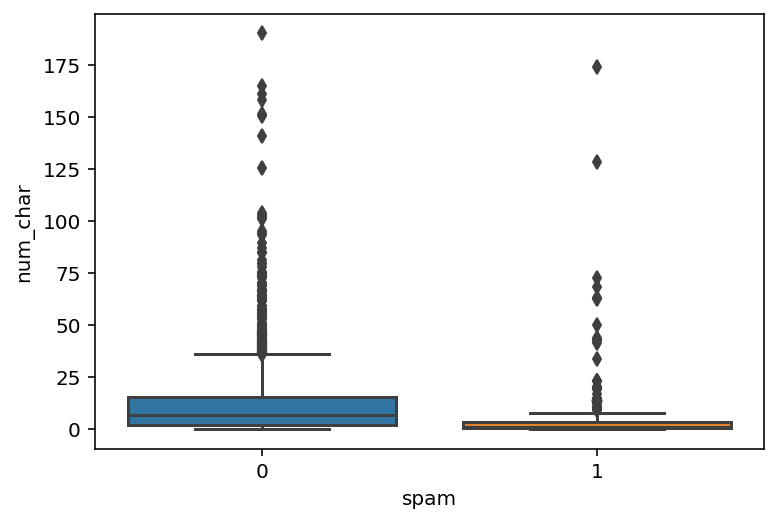

In [72]:
sns.boxplot(data = df_spam, x = 'spam', y = 'num_char')

## Possible markers of spam...

- Maybe emails with the word "winner" are more likely to be spam?

Text(0, 0.5, 'Proportion of spam')

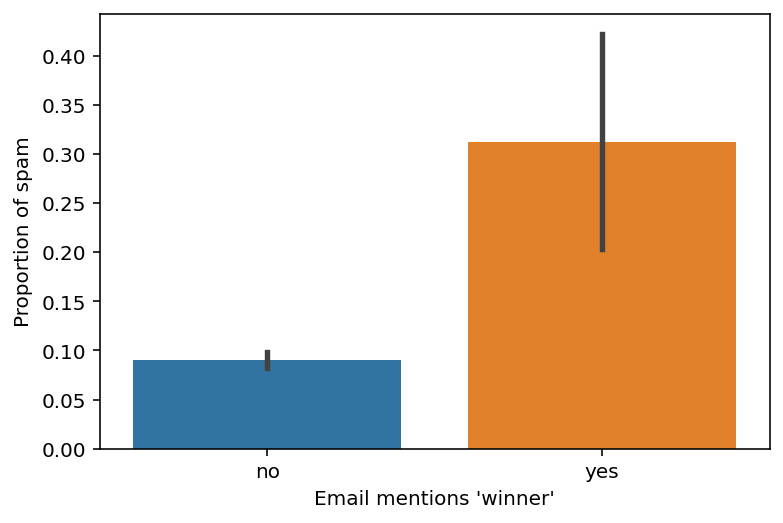

In [73]:
sns.barplot(data = df_spam, x = 'winner', y = 'spam')
plt.xlabel("Email mentions 'winner'")
plt.ylabel("Proportion of spam")

## Why not linear regression?

- We *could* treat `spam` as a continuous response variable and use linear regression.  
- But then our regression line goes beyond $[0, 1]$, which doesn't make any sense for probabilities.

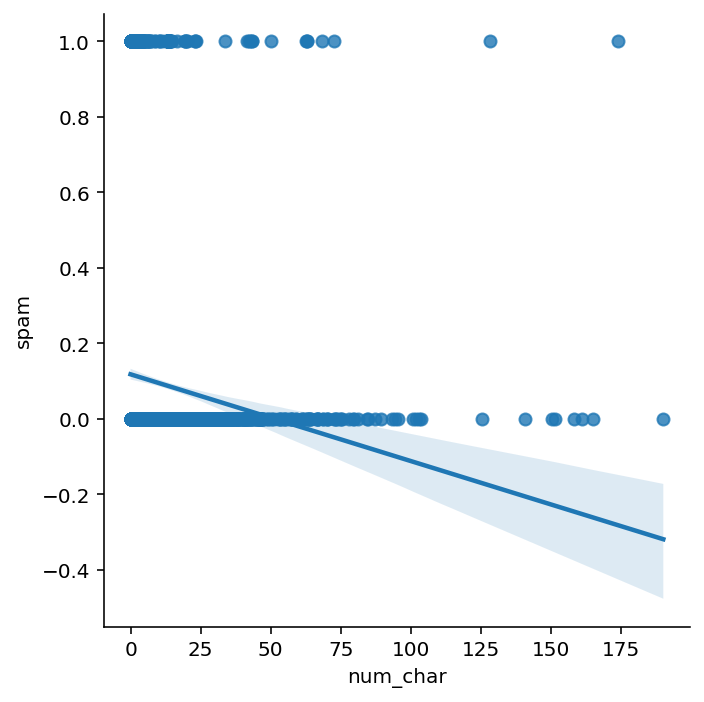

In [74]:
sns.lmplot(data = df_spam,
          x = 'num_char', y = 'spam')

## Framing the problem

- Treat each outcome (`spam` vs. `not spam`) as **Bernoulli trials**, i.e., "success" and "failure".  
- Each trial has an independent probability of success, $p_i$.  
 - In the absence of any other predictors, this would just be the **proportion of spam emails**, i.e., $p(spam)$. 
- We can then use predictors to **model** $p_i$, **conditioned** on those variables.  
 - I.e., $p(spam | winner=True)$  
- As it turns out, we can **transform** the linear model to produce the appropriate range of outputs, $[0, 1]$. 

## Background: generalizing the linear model

- [**Generalized linear models** (GLMs)](https://en.wikipedia.org/wiki/Generalized_linear_model) are generalizations of linear regression. 
- Each GLM has:
 - A probability distribution representing the *generative* model for the outcome variable.  
 - A linear model: $\eta = \beta_0 + \beta_1X_1 + ... + \beta_nX_n$
 - A **link function** relating the linear model to the outcome we're interested in. 
- Logistic regression is a specific kind of GLM.  

### Logistic regression

- Logistic regression uses a **logit link function**.  

$\Large logit(p) = log(\frac{p}{1 - p})$  


- Takes a value between $[0, 1]$ and maps it to a value between $[-\infty, \infty]$.  
- Also called the **log odds**.  

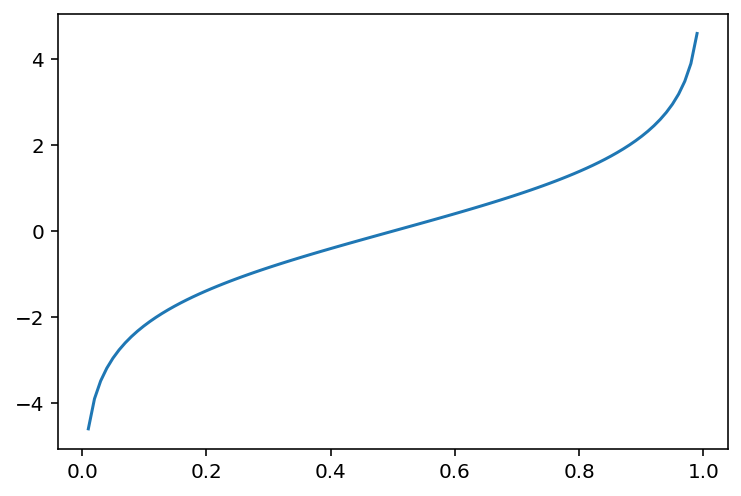

In [82]:
p = np.linspace(0.01, .99, num = 100)
logit = np.log((p/(1-p)))
plot = plt.plot(p, logit)

### Logistic regression

- The **inverse logit function** converts the **log odds** back to probability-space.

$\Large \frac{exp(x)}{1 + exp(x)}$  

- This is also called the **logistic function**.

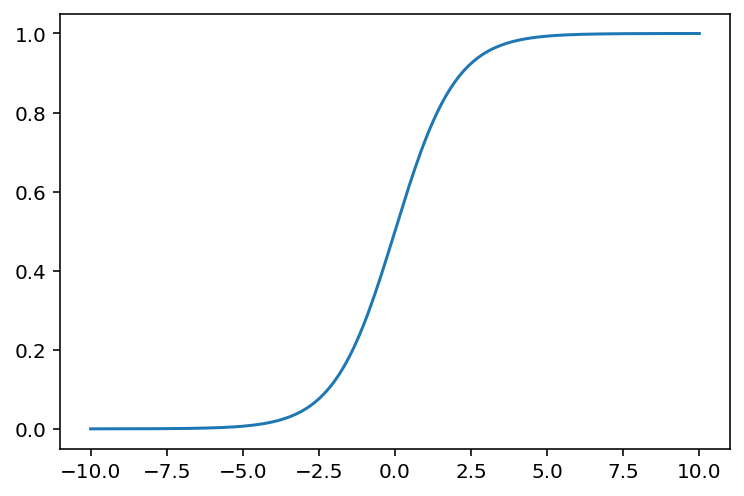

In [84]:
log_odds = np.linspace(-10, 10, num = 200) 
probs = np.exp(log_odds)/ (1 + np.exp(log_odds))
plot = plt.plot(log_odds, probs)

### Logistic regression

- With logistic regression, we're fitting a linear model with a **logit link**.  

$\Large log(\frac{p}{1 - p}) = \beta_0 + \beta_1X_1 + ... + \beta_nX_n$


- Technically, we're learning a linear relationship between $X$ and the **log odds** of our outcome.  


### Check-in: can we interpret each parameter directly as reflecting linear changes in the probability of the outcome?

### Probability ≠ log-odds

- Our parameters $\beta_0, ..., \beta_n$ reflect linear changes in **log-odds**.  
- Log-odds is *not* linearly related to probability.  
- To get probabilities, we need to apply the logistic function.

$\Large \frac{exp(x)}{1 + exp(x)}$  


## Logistic regression in Python

- The `statsmodels` package *also* has a logistic regression method (`logit`).  
- The syntax is basically the same:  
 - `formula`: specifies outcome, predictors, etc.  
 - `data`: specifies dataframe to use.  
 - `fit()`: call this to fit the function.  

### Logistic regression in action

- Let's build a simple model predicting `spam` from `num_char`.  

In [85]:
mod = smf.logit(formula='spam ~ num_char', data=df_spam).fit(disp=0)
mod.summary()

Optimization terminated successfully.
         Current function value: 0.299210
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   spam   No. Observations:                 3921
Model:                          Logit   Df Residuals:                     3919
Method:                           MLE   Df Model:                            1
Date:                Fri, 12 Aug 2022   Pseudo R-squ.:                 0.03725
Time:                        16:00:24   Log-Likelihood:                -1173.2
converged:                       True   LL-Null:                       -1218.6
Covariance Type:            nonrobust   LLR p-value:                 1.607e-21
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.7987      0.072    -25.135      0.000      -1.939      -1.658
num_char      -0.0621      0.008     -7.746      0.000      -0.078      -0.046
==============================================================================
"""

### Check-in: how should we interpret these coefficients?

In [86]:
mod.params

Intercept   -1.798738
num_char    -0.062071
dtype: float64

## Interpreting our model

- We could write this out using the **linear equation**. 

$\Large log(\frac{p}{1 - p}) = -1.8 - 0.06X_{length}$  

- These parameters do *not* directly reflect probabilities.
 - $\beta_0 = -1.8$: predicted **log-odds** of `spam` when $length = 0$.  
 - $\beta_1 = -.06$: for each additional character in an email, predicted change in **log-odds** of `spam`.  

- To extract predicted probabilities, we'd need to:
 - First calculated predicted log-odds.  
 - Then convert to probability-space using the logistic function.
 
 $\Large \frac{exp(x)}{1 + exp(x)}$  

## Extracting probabilities

- What is the predicted `p(spam)` for an email with 0 characters?  
- This is equivalent to the intercept.  

In [87]:
log_odds = -1.8 # Just the intercept
p = np.exp(log_odds) / (1 + np.exp(log_odds))
p

0.1418510649004878

## Extracting probabilities

- What is the predicted `p(spam)` for an email with 100 characters?  

In [88]:
log_odds = -1.8 - .06*100 # Now we add in length
p = np.exp(log_odds) / (1 + np.exp(log_odds))
p

0.00040956716498605043

### Logistic regression with a categorical predictor

- Now let's use `winner` instead of `num_char` as our predictor. 

In [107]:
mod = smf.logit(formula='spam ~ winner', data=df_spam).fit(disp=0)
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   spam   No. Observations:                 3921
Model:                          Logit   Df Residuals:                     3919
Method:                           MLE   Df Model:                            1
Date:                Fri, 12 Aug 2022   Pseudo R-squ.:                 0.01005
Time:                        16:19:25   Log-Likelihood:                -1206.3
converged:                       True   LL-Null:                       -1218.6
Covariance Type:            nonrobust   LLR p-value:                 7.410e-07
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -2.3140      0.056    -41.121      0.000      -2.424      -2.204
winner[T.yes]     1.5256      0.275      5.538      0.000       0.986       2.066
=================================================================================
"""

### Check-in: how should we interpret these coefficients?

In [90]:
mod.params

Intercept       -2.314047
winner[T.yes]    1.525589
dtype: float64

## Extracting probabilities

- What is the predicted `p(spam)` for an email without the word `winner`?  

In [91]:
log_odds = mod.params['Intercept'] # Just the intercept
p = np.exp(log_odds) / (1 + np.exp(log_odds))
p

0.08996629504796422

## Extracting probabilities

- What is the predicted `p(spam)` for an email **with** the word `winner`?  

In [93]:
log_odds = mod.params['Intercept'] + mod.params['winner[T.yes]'] 
p = np.exp(log_odds) / (1 + np.exp(log_odds))
p

0.31250000000000006

## Multiple logistic regression

- As with linear regression, we can add multiple predictors.  

In [106]:
mod = smf.logit(formula='spam ~ winner + num_char', data=df_spam).fit(disp=0)
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   spam   No. Observations:                 3921
Model:                          Logit   Df Residuals:                     3918
Method:                           MLE   Df Model:                            2
Date:                Fri, 12 Aug 2022   Pseudo R-squ.:                 0.05154
Time:                        16:19:05   Log-Likelihood:                -1155.8
converged:                       True   LL-Null:                       -1218.6
Covariance Type:            nonrobust   LLR p-value:                 5.321e-28
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.8291      0.072    -25.412      0.000      -1.970      -1.688
winner[T.yes]     1.9653      0.300      6.542      0.000       1.376       2.554
num_char         -0.0653      0.008     -8.109      0.000      -0.081      -0.050
=================================================================================
"""

### Check-in: how would we interpret the coefficients for multiple logistic regression?

### Check-in: how would we interpret the coefficients for multiple logistic regression?

- Each coefficient $\beta_j$ reflects:
 - **Amount of change** in **log-odds** of outcome associated with changes in $X_j$... 
 - ...holding all other variables **constant** (i.e., *ceteris paribus*).  

### Check-in: how could we measure the "goodness-of-fit" of our models?

## Evaluating our models

- Because our outcome is categorical, traditional $R^2$ won't work.  
- Many approaches:
 - **Accuracy**: if we convert $p_i$ to `spam` ($p_i > .5$) vs. `not spam` ($p_i ≤ .5$), what proportion of our predictions are correct?  
 - [**Precision** vs. **recall**](https://en.wikipedia.org/wiki/Precision_and_recall):
    - Precision: what proportion of emails predicted to be `spam` *are* actually spam?
    - Recall: what proportion of true `spam` was predicted to be spam?  
 - [**Likelihood ratio comparison**](https://seantrott.github.io/model_comparison/): how much more *likely* are our observed data under our full model vs. a simpler model?  
 - [**Akaike Information Criterion**](https://en.wikipedia.org/wiki/Akaike_information_criterion): a measure of model fit rooted in information theory and model likelihood.  
- Much more we could discuss here!

## Extracting AIC. 

- Our fit `model` object has an associated `aic` value.  
- This won't make much sense out of context, so typically we **compare** these AIC values across different models under consideration.  
- A lower AIC value is better.

In [105]:
mod_full = smf.logit(formula='spam ~ winner + num_char', data=df_spam).fit(disp=0)
mod_length = smf.logit(formula='spam ~ num_char', data=df_spam).fit(disp=0)
print("AIC of full model: {x}".format(x = mod_full.aic))
print("AIC of reduced model: {x}".format(x = mod_length.aic))

AIC of full model: 2317.5782764154965
AIC of reduced model: 2350.4011465188078


### Questions on logistic regression?

# Conclusion

- Lots of hard content today, but hopefully you're a little more confident:
 - **Explaining** the motivation for *multivariate linear regression*.  
 - **Implementing** multiple regression in Python using `statmodels`.  
 - **Interpreting** the coefficients from multivariate linear regression models.  
 - **Explaining** the theoretical foundations of logistic regression.